##**Data Import**

In [296]:
!unzip -u "/content/Mask_DB.zip" -d "/content/unzipped_mask_db"

with_mask = "/content/unzipped_mask_db/with_mask"
without_mask = "/content/unzipped_mask_db/without_mask"
wrong_mask = "/content/unzipped_mask_db/mask_incorrect_use"

Archive:  /content/Mask_DB.zip


##**Μέρος 1α)**

In [297]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import random

#custom dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

#function to load and preprocess images
def load_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)
        img_array = np.array(img)
        images.append(img_array)
        labels.append(label)
    return images, labels

#load images and labels for 'with_mask' class
with_mask_images, with_mask_labels = load_images(with_mask, label=1)

#load images and labels for 'without_mask' class
without_mask_images, without_mask_labels = load_images(without_mask, label=0)

#combine the data from both classes
all_images = with_mask_images + without_mask_images
all_labels = with_mask_labels + without_mask_labels

#convert the data to NumPy arrays
X = np.array(all_images)
y = np.array(all_labels)

#split the data into training and testing set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

#create datasets for train validation and test set
train_dataset = CustomDataset(X_train, y_train, transform=transform)
val_dataset = CustomDataset(X_val, y_val, transform=transform)
test_dataset = CustomDataset(X_test, y_test, transform=transform)

#create the dataloaders for the previous datasets
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [298]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(8*8*32, 2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out

cnn = CNN()

In [299]:
print(cnn)
params = list(cnn.parameters())
print("Number of learnable parameters' sets: " , len(params))
for i in params:
  print(i.size())

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=2048, out_features=2, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)
Number of learnable parameters' sets:  10
torch.Size([16, 3, 5, 5])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([2, 2048])
torch.Size([2])


##**Μέρος 1β)**

In [300]:
#hyper-parameters
epochs = 20
learning_rate = 0.001
criterion = nn.CrossEntropyLoss() #loss function
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        #compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        #backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print(f"loss: {loss:>7f}")
    train_losses.append(loss.item())

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    correct_list.append(correct)
    val_losses.append(test_loss)
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Epoch 1
-------------------------------
loss: 0.721135
loss: 0.551465
loss: 0.278745
loss: 0.276830
loss: 0.146311
loss: 0.133994
loss: 0.069901
loss: 0.101274
loss: 0.259641
loss: 0.106632
loss: 0.119918
loss: 0.083042
loss: 0.045707
Accuracy: 78.0%, Avg loss: 0.456267 

Epoch 2
-------------------------------
loss: 0.107364
loss: 0.090939
loss: 0.057463
loss: 0.130505
loss: 0.096558
loss: 0.133935
loss: 0.034144
loss: 0.042686
loss: 0.100420
loss: 0.117300
loss: 0.102333
loss: 0.120719
loss: 0.156475
Accuracy: 78.5%, Avg loss: 0.378985 

Epoch 3
-------------------------------
loss: 0.029917
loss: 0.073700
loss: 0.063709
loss: 0.139888
loss: 0.095940
loss: 0.114961
loss: 0.047902
loss: 0.041402
loss: 0.027569
loss: 0.084912
loss: 0.059089
loss: 0.060567
loss: 0.081864
Accuracy: 91.9%, Avg loss: 0.210837 

Epoch 4
-------------------------------
loss: 0.087888
loss: 0.072281
loss: 0.028863
loss: 0.049323
loss: 0.125533
loss: 0.037693
loss: 0.034030
loss: 0.037662
loss: 0.050383
loss: 

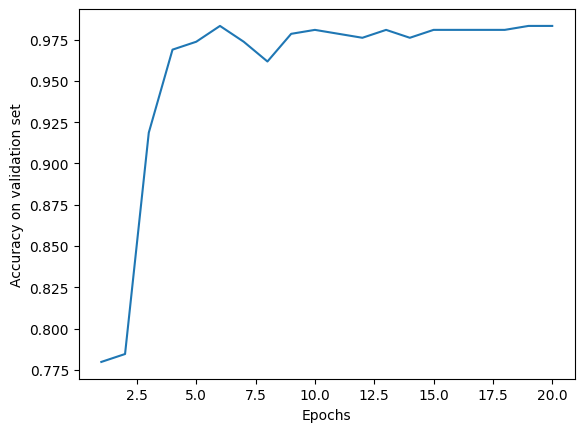

In [301]:
correct_list = []
train_losses = []
val_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, cnn, criterion, optimizer)
    test_loop(val_loader, cnn, criterion)
print("Done!")

plt.plot(range(1,epochs+1),correct_list)
plt.xlabel("Epochs")
plt.ylabel("Accuracy on validation set")
plt.show()

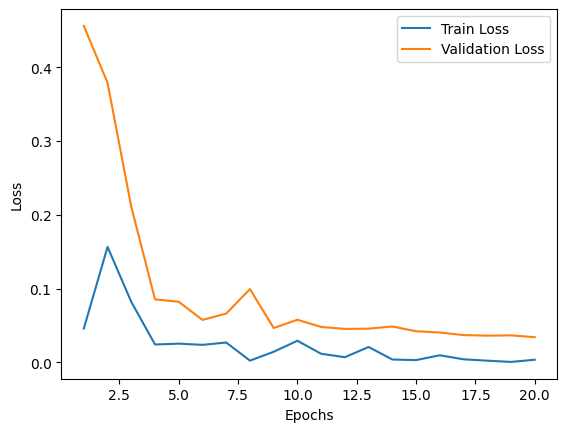

In [302]:
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##**Μέρος 1γ)**

In [303]:
print("Test set")
test_loop(test_loader, cnn, criterion)

Test set
Accuracy: 98.6%, Avg loss: 0.063000 



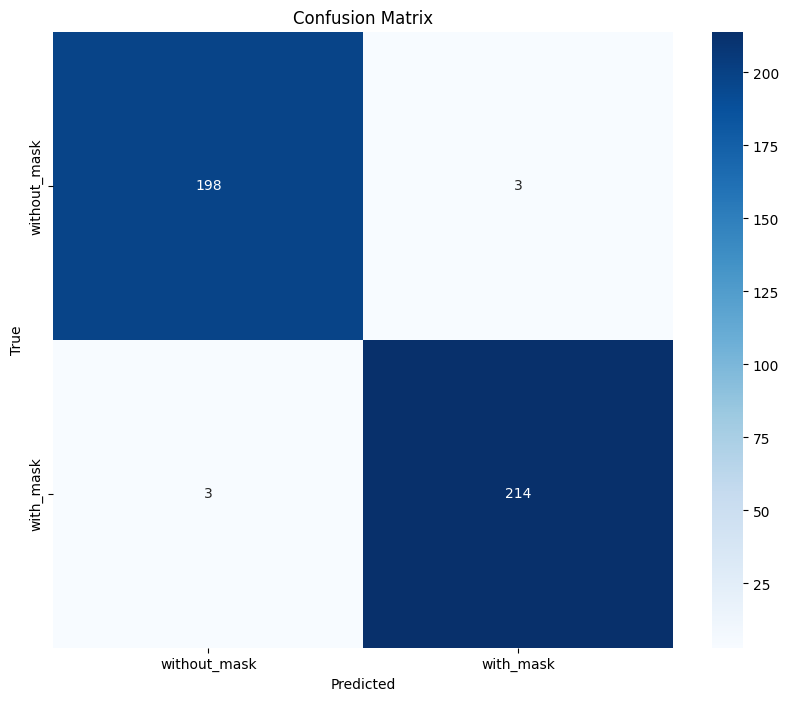

In [304]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

cnn.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = cnn(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
classes = ('without_mask', 'with_mask')

#plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[f"{i}" for i in classes],
            yticklabels=[f"{i}" for i in classes])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

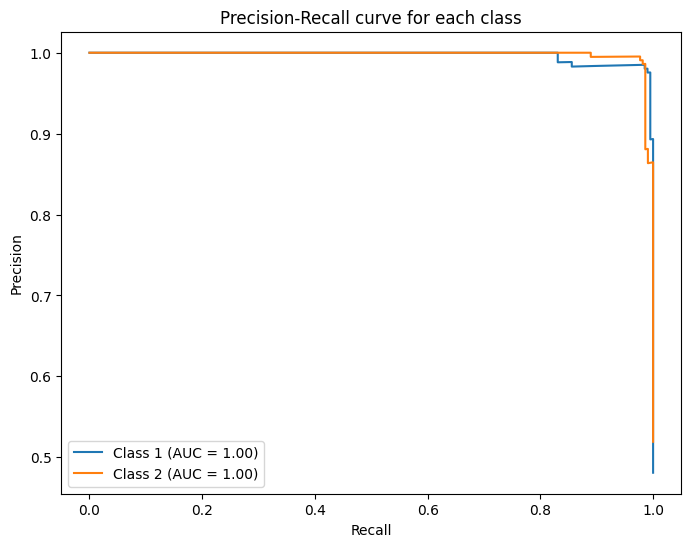

In [305]:
from sklearn.metrics import precision_recall_curve, auc
import torch.nn.functional as F

#set the model to evaluation mode
cnn.eval()

#create lists to store labels and predictions
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = cnn(inputs)
        #transform the output into probabilities
        probs = F.softmax(outputs, dim=1)
        all_predictions.extend(probs.numpy())
        all_labels.extend(labels.numpy())

#convert predictions and labels to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

#plot precision - recall curves for each class
precision = []
recall = []
auc_scores = []

#calculate precision and recall for each class
for i in range(2):
    prec, rec, _ = precision_recall_curve((all_labels == i).astype(int), all_predictions[:, i])
    precision.append(prec)
    recall.append(rec)
    auc_scores.append(auc(recall[i], precision[i]))

#plot the precision - recall curves
plt.figure(figsize=(8, 6))

for i in range(2):
    plt.plot(recall[i], precision[i], label=f'Class {i+1} (AUC = {auc_scores[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class')
plt.legend()
plt.show()

##**Μέρος 1δ)**

In [306]:
#create the dataset and the dataloader with wrong mask usage images

wrong_mask_images, wrong_mask_labels = load_images(wrong_mask, label=1)

test2_dataset = CustomDataset(wrong_mask_images, wrong_mask_labels, transform=transform)

test2_loader = DataLoader(test2_dataset, batch_size=1, shuffle=False)

print("Incorrect mask usage recognized as with mask")
test_loop(test2_loader, cnn, criterion)

Incorrect mask usage recognized as with mask
Accuracy: 85.7%, Avg loss: 0.746954 



1ος Τρόπος

In [312]:
#perform data augmentation on the wrong mask usage images

augmentation_transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-90, 90)),
    #transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0), ratio=(0.85, 1.05)),
    transforms.ToTensor(),
])

test3_dataset = CustomDataset(wrong_mask_images, wrong_mask_labels, transform=augmentation_transform)
test3_loader = DataLoader(test3_dataset, batch_size=1, shuffle=False)

print("With data augmentation")
test_loop(test3_loader, cnn, criterion)

With data augmentation
Accuracy: 48.2%, Avg loss: 0.726437 



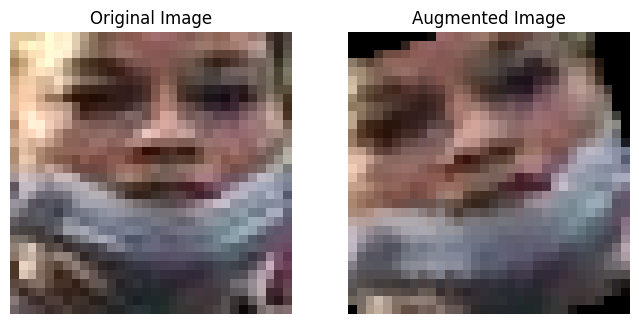

In [338]:
import torchvision.transforms.functional as F2
random_image = random.randint(0, len(test3_dataset) - 1)

#display the original image
original_image = wrong_mask_images[random_image]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title(f"Original Image")
plt.imshow(F2.to_pil_image(original_image))
plt.axis("off")

#display the augmented image
augmented_sample = test3_dataset[random_image]
augmented_image, _ = augmented_sample

plt.subplot(1, 2, 2)
plt.title(f"Augmented Image")
plt.imshow(F2.to_pil_image(augmented_image))
plt.axis("off")

plt.show()

2ος Τρόπος


In [325]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred_logits = model(X)
            pred_probabilities = torch.softmax(pred_logits, dim=1)
            #apply threshold in order to assign a sample in a class
            pred_binary = (pred_probabilities[:, 1] > 0.999).long()

            test_loss += loss_fn(pred_logits, y).item()
            correct += (pred_binary == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    correct_list.append(correct)
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [326]:
print("Test set accuracy when using the new threshold")
test_loop(test_loader, cnn, criterion)

Test set accuracy when using the new threshold
Accuracy: 90.4%, Avg loss: 0.066242 



In [327]:
print("Incorrect mask usage recognized as with mask")
test_loop(test2_loader, cnn, criterion)

Incorrect mask usage recognized as with mask
Accuracy: 55.4%, Avg loss: 0.746954 

